In [1]:
import numpy as np
import pandas as pd

import re
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression, RidgeClassifier, SGDClassifier
import lightgbm
import xgboost
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

SEED = 1

In [2]:
#Read the data
dataset = pd.read_csv('Data.csv', usecols=['id', 'article','label'])

In [3]:
#Get shape
dataset.shape

(1272, 3)

In [4]:
dataset.head()

,id,article,label
0,10909,article 7. - le conseil des professeurs il est...,Not Zone
1,571,article 3. — les ouvrages ou installations son...,Not Zone
2,10509,article l. 365-1. - la responsabilité civile o...,Not Zone
3,2572,article 23. le conseil d'administration ne peu...,Not Zone
4,36,article 14. - sur la base du compte rendu de r...,Not Zone


In [6]:
label_0 = dataset[dataset['label']=='Not Zone'].value_counts()
print(label_0.shape)

label_1 = dataset[dataset['label']=='Zone'].value_counts()
print(label_1.shape)

(636,)
(636,)


In [7]:
data = dataset.groupby('label', group_keys=False).apply(lambda x: x.sample(dataset.label.value_counts().min()))
data.shape

(1272, 3)

In [8]:
label_0 = data[data['label']=='Not Zone'].value_counts()
print(label_0.shape)

label_1 = data[data['label']=='Zone'].value_counts()
print(label_1.shape)

(636,)
(636,)


In [9]:
data['label'].unique()

array(['Not Zone', 'Zone'], dtype=object)

In [10]:
data = data.dropna()

In [11]:
data['label'].unique()

array(['Not Zone', 'Zone'], dtype=object)

In [12]:
#Get shape
data.shape

(1272, 3)

In [13]:
label_0 = data[data['label']=='Not Zone'].value_counts()
print(label_0.shape)

label_1 = data[data['label']=='Zone'].value_counts()
print(label_1.shape)

(636,)
(636,)


# Modeling using ML models:

In [15]:
# def preprocess_text(text: str, remove_stopwords: bool) -> str:
def preprocess_text(text):
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """
    
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
#     if remove_stopwords:
    # 1. tokenize
    tokens = nltk.word_tokenize(text)
    # 2. check if stopword
    tokens = [w for w in tokens if not w.lower() in stopwords.words("french")]
    # 3. join back together
    text = " ".join(tokens)
    
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [16]:
data_preprocessed = data.copy()

In [17]:
data_preprocessed["article"] = data_preprocessed["article"].apply(preprocess_text)
data_preprocessed.head(10)

,id,article,label
170,150,article pr sente loi applique paves bris paves...,Not Zone
465,85,article ler ler application article sbis loi j...,Not Zone
126,587,article directeur transport maritime ports lit...,Not Zone
53,706,article conformit r glementation service envir...,Not Zone
23,10,article demande agr ment doit tre formul e pos...,Not Zone
464,5422,article commission peut faire appel toute pers...,Not Zone
70,1166,article dimentions caract tres identification ...,Not Zone
382,5686,article agence national affaires maritimes cha...,Not Zone
363,19261,article composition conseil administration con...,Not Zone
73,330,article fins pr sente charte entend a charte m...,Not Zone


In [18]:
#Get shape
data_preprocessed.shape

(1272, 3)

In [19]:
stemmer = SnowballStemmer("french")
data_preprocessed['article'] = data_preprocessed['article'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

data.head(10)

,id,article,label
170,150,article 3. la présente loi ne s'applique pas a...,Not Zone
465,85,article ler. § ler. en application de l'articl...,Not Zone
126,587,article 5. - le directeur du transport maritim...,Not Zone
53,706,article 49: -10-conformité avec la réglementat...,Not Zone
23,10,article 13. - la demande d'agrément doit être ...,Not Zone
464,5422,article 8 — la commission peut faire appel à t...,Not Zone
70,1166,article 10. - les dimentions des caractètres d...,Not Zone
382,5686,article 3. - l'agence national des affaires ma...,Not Zone
363,19261,article 8: composition du conseil d'administra...,Not Zone
73,330,"article 1 : aux fins de la présente charte, on...",Not Zone


In [20]:
print(data_preprocessed.iloc[0]['article'])

articl pr sent loi appliqu pav bris pav relev champ appliqu chapitr titr livr cod belged navig pipelin ble pos fond marin install autr pipelin ble plac fond marin encor usag chapitr patrimoin culturel subaquat zon maritim belg


In [21]:
data_preprocessed['label'] = data_preprocessed['label'].replace('Zone', 1)
data_preprocessed['label'] = data_preprocessed['label'].replace('Not Zone', 0)

In [22]:
data_preprocessed.head()

,id,article,label
170,150,articl pr sent loi appliqu pav bris pav relev ...,0
465,85,articl ler ler appliqu articl sbis loi janvi v...,0
126,587,articl directeur transport maritim port lit to...,0
53,706,articl conform r glement servic environ adress...,0
23,10,articl demand agr ment doit tre formul e postu...,0


In [23]:
data_preprocessed['label'].unique()

array([0, 1], dtype=int64)

In [24]:
#DataFlair - Get the labels
labels = data_preprocessed.label

In [25]:
#DataFlair - Split the dataset
X_train, X_test, y_train, y_test = train_test_split(data_preprocessed['article'], labels, test_size=0.15, stratify=labels)

In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1081,), (191,), (1081,), (191,))

In [27]:
#DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, stop_words=stopwords.words('french'))

#DataFlair - Fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [60]:
f = open('./tfidf_vectorizer.pkl', 'wb')
pickle.dump(tfidf_vectorizer, f)
f.close()

In [28]:
lr = LogisticRegression(random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
pac = PassiveAggressiveClassifier(random_state=SEED)##
lgb = lightgbm.LGBMClassifier(random_state=SEED)
ridge = RidgeClassifier(random_state=SEED)##
rfc = RandomForestClassifier(random_state=SEED)
svc = SVC(random_state=SEED)##
sdgc = SGDClassifier(random_state=SEED)##
mnnb = MultinomialNB()

In [29]:
classifiers = [('Logistic Regression', lr),
               ('XGBoost CLassifier', xgb),
               ('Passive Aggressive Classifier', pac),
               ('Light GBM Classifier', lgb),
               ('Ridge Classifier', ridge),
               ('RandomForestClassifier', rfc),
               ('SVC', svc),
               ('SGDClassifier', sdgc),
               ('MultinomialNB', mnnb)
              ]

In [30]:
for clf_name, clf in classifiers:
    #fit clf to the training set
    clf.fit(tfidf_train, y_train)
    
    #Predict the labels of the test set
    y_pred = clf.predict(tfidf_test)
    
    #Evaluate the accuracy of clf on the test set
    score = accuracy_score(y_test, y_pred)
    print("{:s} : {:}%".format(clf_name, round(score*100, 2)))

Logistic Regression : 96.34%
XGBoost CLassifier : 95.29%
Passive Aggressive Classifier : 96.86%
Light GBM Classifier : 96.34%
Ridge Classifier : 95.81%
RandomForestClassifier : 92.67%
SVC : 95.29%
SGDClassifier : 95.29%
MultinomialNB : 94.76%


In [32]:
vc = VotingClassifier(estimators=classifiers)

vc.fit(tfidf_train, y_train)
y_pred = vc.predict(tfidf_test)

score = accuracy_score(y_test, y_pred)
print("Voting Classifier : {:}%".format(round(score*100, 2)))

Voting Classifier : 96.34%


In [33]:
import joblib

# Save the classifier to a file
joblib.dump(vc, 'Classifier_Zone_Not_Zone.pkl')

# Load the classifier from the file
voting_clf = joblib.load('Classifier_Zone_Not_Zone.pkl')

In [34]:
name = "model_96.34"

In [35]:
f = open('./'+name+'.pkl', 'wb')
pickle.dump(vc, f)
f.close()

In [36]:
# f = open('./'+name+'.pkl', 'rb')
# classifier = pickle.load(f)
# f.close()

# Test:

In [37]:
#DataFlair - Build confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[93  2]
 [ 5 91]]


In [38]:
label_0 = y_test[y_test==0].value_counts()
print(label_0)

label_1 = y_test[y_test==1].value_counts()
print(label_1)

0    95
Name: label, dtype: int64
1    96
Name: label, dtype: int64


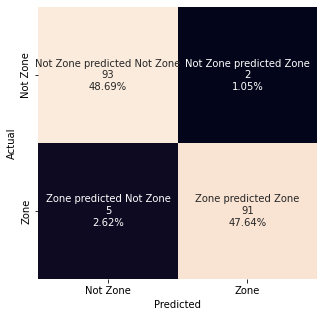

In [42]:
group_names = ['Not Zone predicted Not Zone', 'Not Zone predicted Zone', 'Zone predicted Not Zone', 'Zone predicted Zone']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(5,5));
sns.heatmap(cf_matrix, annot=labels, fmt='', xticklabels=['Not Zone', 'Zone'], yticklabels=['Not Zone', 'Zone'], cbar=False);
plt.ylabel('Actual');
plt.xlabel('Predicted');

In [43]:
def test_model(model, article):
    article_preprocessed = preprocess_text(article)
    article_preprocessed_1 = ' '.join([stemmer.stem(word) for word in article_preprocessed.split()])
    tfidf_article = tfidf_vectorizer.transform([article_preprocessed_1])
    prediction = model.predict(tfidf_article)
    if prediction[0] == 1:
        return 'Zone'
    return 'Not Zone'

# Active learning:

In [45]:
#Read the data
unlabeled_data = pd.read_csv('Other_Articles.csv', usecols=['Article'])#, usecols=['text','label'])

In [46]:
unlabeled_data.shape

(13992, 1)

In [49]:
unlabeled_data.columns = ['article']

In [50]:
unlabeled_data.head()

,article
0,Article premier La largeur des zones maritimes...
1,Article 3 Les eaux comprises dans les lignes d...
2,Article 4 Le présent décret sera publié au Jou...
3,Article 1: La largeur des eaux territoriales a...
4,Article 2 : A l’intérieur des eaux territorial...


In [51]:
unlabeled_data['article'] = unlabeled_data['article'].apply(lambda x: " ".join(x.strip().lower().split()))

In [52]:
data_to_annotate = pd.concat([data.drop(columns=['label', 'id']), unlabeled_data])

In [53]:
data_to_annotate.shape

(15264, 1)

In [54]:
data_to_annotate.drop_duplicates(keep=False, inplace=True)

In [55]:
data_to_annotate.shape

(8722, 1)

In [56]:
data_to_annotate['index'] = data_to_annotate.index

In [57]:
data_to_annotate.head()

,article,index
73,"article 1 : aux fins de la présente charte, on...",73
307,"article 1"""". - aux fins des articles 32 4 39 l...",307
521,article 31. les exploitations ne peuvent avoir...,521
536,"article 9. - les centres régionaux, prévus ci-...",536
290,article premier est inséré dans le code de la ...,290


In [58]:
data_preprocessed_to_annotate = data_to_annotate.copy()

In [59]:
# data["article"] = data["article"].apply(lambda x: preprocess_text(x, remove_stopwords=True))
data_preprocessed_to_annotate["article"] = data_preprocessed_to_annotate["article"].apply(preprocess_text)
data_preprocessed_to_annotate.head(10)

,article,index
73,article fins pr sente charte entend a charte m...,73
307,article fins articles ordonnance prg mai porta...,307
521,article exploitations peuvent avoir lieu zones...,521
536,article centres r gionaux pr vus ci dessus hab...,536
290,article premier ins r code mer troisi partie a...,290
4,article base compte rendu reconnaissance fonct...,4
236,article attendant promulgation loi portant cod...,236
186,article fins pr sent arr entend ministre minis...,186
45,article premier ministre charg ex cution pr se...,45
288,article er application articles ordonnance prg...,288


In [60]:
#Get shape
data_preprocessed_to_annotate.shape

(8722, 2)

In [61]:
stemmer = SnowballStemmer("french")
data_preprocessed_to_annotate['article'] = data_preprocessed_to_annotate['article'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

data_preprocessed_to_annotate.head(10)

,article,index
73,articl fin pr sent chart entend a chart mariti...,73
307,articl fin articl ordon prg mai port cod envri...,307
521,articl exploit peuvent avoir lieu zon contr se...,521
536,articl centr r gional pr vus ci dessus habil o...,536
290,articl premi in r cod mer trois part arr minis...,290
4,articl bas compt rendu reconnaiss fonction gra...,4
236,articl attend promulg loi port cod p troli r p...,236
186,articl fin pr sent arr entend ministr ministr ...,186
45,articl premi ministr charg ex cution pr sent c...,45
288,articl er appliqu articl ordon prg mai port co...,288


In [62]:
#Get shape
data_preprocessed_to_annotate.shape

(8722, 2)

In [65]:
Classifiers = [('Logistic Regression', lr),
               ('XGBoost CLassifier', xgb),
               ('Light GBM Classifier', lgb),
               ('RandomForestClassifier', rfc),
               ('MultinomialNB', mnnb)
              ]

In [66]:
voting_classifier = VotingClassifier(estimators=Classifiers, voting='soft')

voting_classifier.fit(tfidf_train, y_train)
y_pred = voting_classifier.predict(tfidf_test)

score = accuracy_score(y_test, y_pred)
print("Voting Classifier : {:}%".format(round(score*100, 2)))

Voting Classifier : 95.81%


In [67]:
def prob(model, article):
    article_preprocessed = preprocess_text(article)
    article_preprocessed = ' '.join([stemmer.stem(word) for word in article_preprocessed.split()])
    tfidf_article = tfidf_vectorizer.transform([article_preprocessed])
    prediction = model.predict_proba(tfidf_article)
    return [article, prediction[0][0], prediction[0][1]]

In [68]:
liste = []
for i in data_to_annotate['article']:
    liste.append(prob(voting_classifier, i))

In [69]:
len(liste)

8722

In [70]:
df = pd.DataFrame(liste)
df.columns = ['article', 'Not Zone', 'Zone']
df.head()

,article,Not Zone,Zone
0,"article 1 : aux fins de la présente charte, on...",0.955909,0.044091
1,"article 1"""". - aux fins des articles 32 4 39 l...",0.897098,0.102902
2,article 31. les exploitations ne peuvent avoir...,0.877191,0.122809
3,"article 9. - les centres régionaux, prévus ci-...",0.848470,0.151530
4,article premier est inséré dans le code de la ...,0.776979,0.223021


In [71]:
df_high_labeled_zone = df[df['Zone'] >= 0.95][['article', 'Zone']]
df_high_labeled_not_zone = df[df['Not Zone'] >= 0.95][['article', 'Not Zone']]

In [72]:
df_high_labeled_zone.shape, df_high_labeled_not_zone.shape

((0, 2), (216, 2))

In [73]:
for index, row in df_high_labeled_zone.iterrows():
    idx = random.randint(1, 20000)
    while idx in dataset['id']:
        idx = random.randint(1, 20000)
    new_row = {'id':idx, 'article':row["article"], 'label':'Zone'}
    dataset = dataset.append(new_row, ignore_index=True)

In [74]:
dataset.shape

(1272, 3)

In [75]:
for index, row in df_high_labeled_not_zone.iterrows():
    idx = random.randint(1, 20000)
    while idx in dataset['id']:
        idx = random.randint(1, 20000)
    new_row = {'id':idx, 'article':row["article"], 'label':'Not Zone'}
    dataset = dataset.append(new_row, ignore_index=True)

In [76]:
dataset.shape

(1272, 3)

In [319]:
dataset.to_csv('Data.csv')